In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [2]:
 from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [4]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
# we compute the correlation matrix using the corr method for data frames
Smarket.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

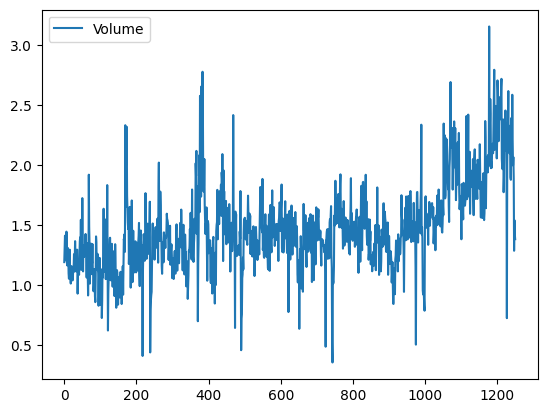

In [6]:
Smarket.plot(y='Volume')

### LOGISTIC REGRESSION

In [7]:
# we will fit a logistic direction using Lag1 through Lag5 and Volume.
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

# the sm.GLM() function fits generalized linear models
glm = sm.GLM(y, X, family = sm.families.Binomial())
results = glm.fit()
# By analyzing results there's no clear evidence of a real association between Lag1 and Direction
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [8]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [9]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [10]:
# the predict() method of results can be used to predict the probability that the market will go up, given values of the predictors.
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [11]:
# the following two commands create a vector of class predictions based on whether the predicted probability of a market increase
# is greater or less than 0.5
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = 'Up'

In [12]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [13]:
# compute the fraction of days for which the prediction was correct.
np.mean(labels == Smarket.Direction)

0.5216

In [14]:
# In order to better assess the accuracy of the logistic regression model, we can fit the model using part of the data
# and then examine how well it predicts the held out data.
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [15]:
# we now fit the logistic regression model
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [16]:
D = Smarket.Direction

In [17]:
L_train, L_test = D.loc[train], D.loc[~train]

In [18]:
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [19]:
# Here we evaluate test accuracy and test error rate. Worst than random guessing...
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [20]:
# now we refit the model by considering the variables Lag1 and Lag2, which seems to have the higher predictive power.
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [21]:
np.mean(labels == L_test)

0.5595238095238095

In [22]:
#suppose to predict particolar values of Lag1 and Lag2
newdata = pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

### LINEAR DISCRIMINANT ANALYSIS

In [23]:
lda = LDA(store_covariance=True)

In [24]:
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [25]:
# it extract the means in the two classes:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [26]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [27]:
# The LDA output are (down, up):
lda.priors_

array([0.49198397, 0.50801603])

In [28]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [29]:
# linear combination of Lag1 and Lag2
lda_pred = lda.predict(X_test)

In [30]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [31]:
#we can estimate the probability of eah class for each point.
# We use this function that creates 
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up', 'Down') == lda_pred)

True

In [32]:
# For problems with more than two classes the labels are chosen as the class whose posterior probability is the highest
np.all([lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred)

True

In [33]:
# To use a posterior probability threshold other than 50% we have to set:
np.sum(lda_prob[:,0] > 0.9)

0

### Quadratic Discriminant Analysis

In [34]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [35]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [36]:
#the output contains the group means
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [37]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [38]:
np.mean(qda_pred == L_test)

0.5992063492063492

### Naive Bayes

In [39]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [40]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [41]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [42]:
#mean of the features (2 in this case)
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [43]:
#variance of the features
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [44]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [45]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [46]:
# same syntax as for LDA and QDA
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [47]:
# the predict_proba() method estimates the probability that each observation belongs to a particular class
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

### K-Nearest Neighbour

In [48]:
# we fit the classifier:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [49]:
np.mean(knn1_pred == L_test)

0.5

In [50]:
# we repeat the analysis by setting K = 3
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

In [51]:
# KNN does not perform well on the Smarket data, but in general it proveides outstanding performances.
# We extract the Caravan dataset from ISLP
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [52]:
# our features will include all columns except Purchase
feature_df = Caravan.drop(columns=['Purchase'])

In [53]:
# KNN predicts based on distance, so there's the need to standardize variables, in order to avoid inappropriate predictions
# A nice function is StandardScaler(); 
# with_mean indicates whether or not we should subtract the mean
# with_std indicates whether or not we should scale the columns to have std of 1
# copy = true states we'll always copy data instead of trying to do calculations
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

In [54]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [55]:
feature_std = pd.DataFrame(X_std, columns=feature_df.columns);
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [56]:
feature_std

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,0.680906,-0.27258,0.406697,-1.216964,0.779405,-0.694311,0.217444,-0.068711,-0.161816,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
1,0.992297,-0.27258,-0.859500,-1.216964,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
2,0.992297,-0.27258,-0.859500,-1.216964,0.779405,-0.694311,-0.365410,0.914172,0.464159,-1.667319,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
3,-1.187437,-0.27258,0.406697,0.010755,-0.970980,1.299414,-0.948264,0.914172,0.464159,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
4,1.225840,-0.27258,1.672893,-1.216964,1.479559,0.302552,-0.365410,-0.068711,0.464159,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,0.914449,-0.27258,-2.125697,-1.216964,0.779405,-0.694311,0.800298,-0.068711,-0.787790,-2.714813,...,5.094585,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5818,0.836602,-0.27258,1.672893,1.238473,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5819,0.680906,-0.27258,0.406697,1.238473,0.779405,-0.694311,0.800298,-1.051594,-0.161816,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5820,0.758754,-0.27258,0.406697,-1.216964,0.779405,-0.694311,1.383152,-1.051594,-0.787790,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816


In [57]:
#?train_test_split
(X_train,X_test,y_train,y_test) = train_test_split(feature_std,Purchase,test_size=1000,random_state=0)

In [58]:
#Set max_loky to avoid warnings
%env LOKY_MAX_CPU_COUNT=0
# We fit the model using K = 1

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

env: LOKY_MAX_CPU_COUNT=0


(0.111, 0.067)

In [59]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


#### TUNING PARAMETERS

In [60]:
# We can tune the hyperparameters using a for loop or some optimization algorithm
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' + ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(K, pred, did_rent, did_rent / pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 19, # who did rent 3, accuracy 15.8%
K=4: # predicted to rent:  3, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


#### Comparison to Logistic Regression

In [61]:
# sklearn focuses less on inference and more on classification
# we uesd the argument solver = 'liblinear' to avoid a warning in the default solver
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


In [63]:
# we choose a 0.25 cutoff threshold
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
# logit_labels
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


#### Linear and Poisson Regression on the Bikeshare Data

In [65]:
Bike = load_data('Bikeshare')

In [66]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

##### LINEAR REGRESSION

In [67]:
X = MS(['mnth', 'hr', 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


In [69]:
# I use a different coding for variables hr and mnth
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [71]:
#?contrast

In [74]:
# the coefficients of hr and mnth in M2_lm will always sum to zero and can be interpreted as the difference from the mean level. 
X2 = MS([mnth_encode, hr_encode, 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In [75]:
# We see the predictions from the linear model are regardless of coding.
# The sum of squaerd differences is 0
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)

8.424745277158568e-19

In [77]:
# It's the same as above
np.allclose(M_lm.fittedvalues , M2_lm.fittedvalues)

True

In [78]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [79]:
#We append Dec as the negative of the sum of all other months
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

Text(0, 0.5, 'Coefficient')

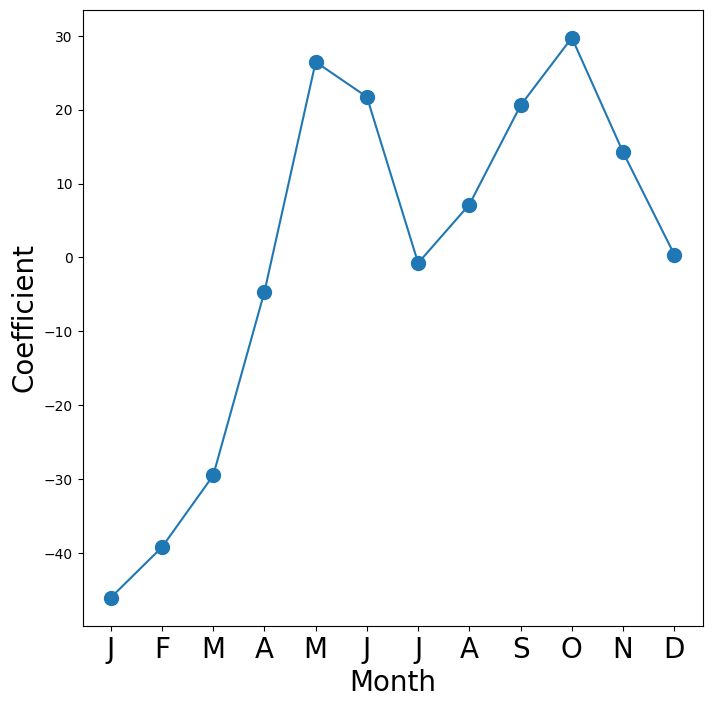

In [81]:
fig_month, ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize =20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)


In [85]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])])
coef_hr

hr[0]     -96.1420
hr[1]    -110.7213
hr[2]    -117.7212
hr[3]    -127.2828
hr[4]    -133.0495
hr[5]    -120.2775
hr[6]     -75.5424
hr[7]      23.9511
hr[8]     127.5199
hr[9]      24.4399
hr[10]    -12.3407
hr[11]      9.2814
hr[12]     41.1417
hr[13]     39.8939
hr[14]     30.4940
hr[15]     35.9445
hr[16]     82.3786
hr[17]    200.1249
hr[18]    173.2989
hr[19]     90.1138
hr[20]     29.4071
hr[21]     -8.5883
hr[22]    -37.0194
hr[23]    -69.3046
dtype: float64

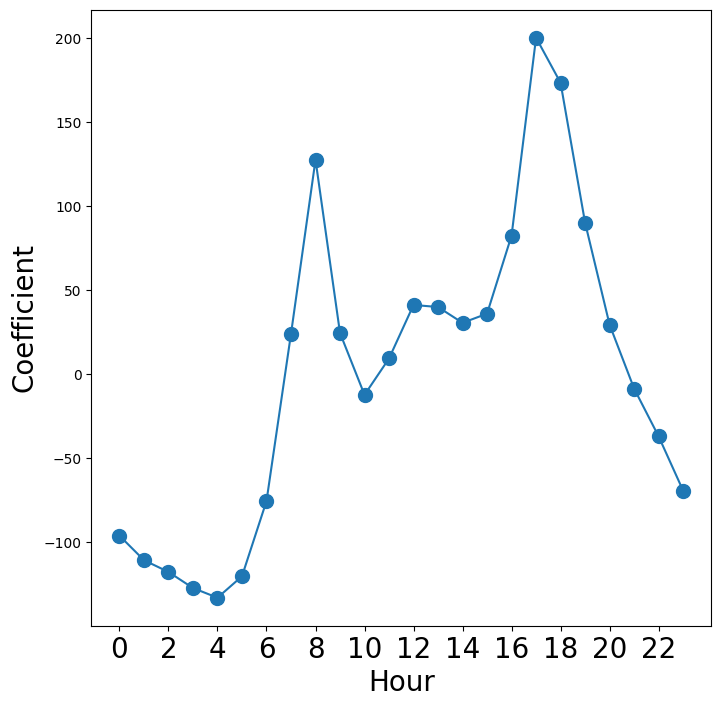

In [84]:
#Hourly plot
fig_hr, ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

##### POISSON REGRESSION

In [99]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [101]:
S_pois = summarize(M_pois)
S_pois

,coef,std err,z,P>|z|
intercept,4.1182,0.006,683.963,0.0
mnth[Jan],-0.6702,0.006,-113.445,0.0
mnth[Feb],-0.4441,0.005,-91.379,0.0
mnth[March],-0.2937,0.004,-70.886,0.0
mnth[April],0.0215,0.003,6.888,0.0
mnth[May],0.2405,0.003,82.462,0.0
mnth[June],0.2232,0.004,62.818,0.0
mnth[July],0.1036,0.004,25.121,0.0
mnth[Aug],0.1512,0.004,41.281,0.0
mnth[Sept],0.2335,0.003,75.281,0.0


In [93]:
# we plot the coefficients associated with mnth and hour
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])])

In [94]:
# Evaluate the coefficients
#coef_month
coef_hr

hr[0]    -0.7544
hr[1]    -1.2260
hr[2]    -1.5631
hr[3]    -2.1983
hr[4]    -2.8305
hr[5]    -1.8147
hr[6]    -0.4299
hr[7]     0.5752
hr[8]     1.0769
hr[9]     0.5818
hr[10]    0.3369
hr[11]    0.4941
hr[12]    0.6796
hr[13]    0.6736
hr[14]    0.6249
hr[15]    0.6538
hr[16]    0.8743
hr[17]    1.2946
hr[18]    1.2123
hr[19]    0.9140
hr[20]    0.6162
hr[21]    0.3642
hr[22]    0.1175
hr[23]   -0.2730
dtype: float64

Text(0, 0.5, 'Coefficient')

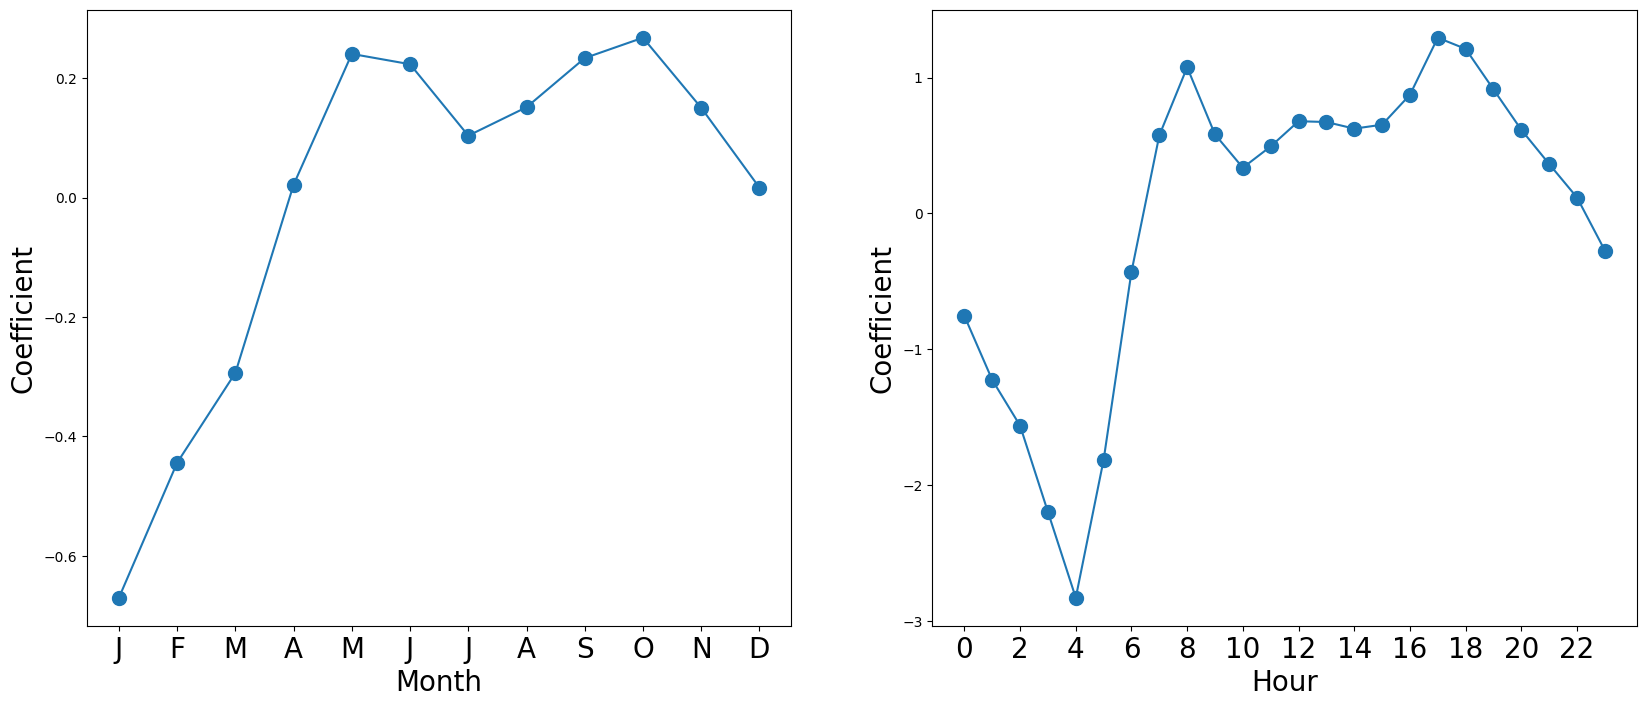

In [114]:
fig_pois, (ax_month, ax_hr) = subplots(1, 2, figsize=(20,8))
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize = 20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(0,24,2), fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20)

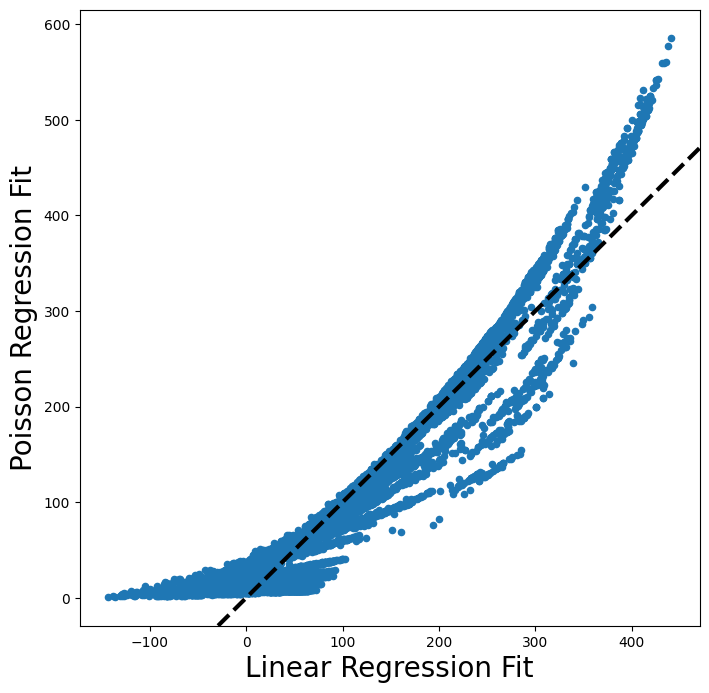

In [96]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues , M_pois.fittedvalues, s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
linestyle='--', slope=1);